In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.decomposition import PCA
import pymc as pm
from scipy.spatial import distance_matrix
from scipy.linalg import block_diag
from scipy.stats import multivariate_normal, norm
from sklearn.linear_model import LinearRegression
import theano.tensor as tt
plt.style.use('ggplot')
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
os.chdir('../')
from python_code import basic_gibbs
os.chdir('notebooks')

In [23]:
df = pd.read_csv('../formatted_data/transformed_data.csv')
#df = df[df['department_name'].isin(np.unique(df['department_name'])[0:2])]
grouped_df = df.groupby('department_name')
groups = list(grouped_df.groups.keys())
X_depts = list(grouped_df.apply(lambda x: np.array(x[['intercept', 'component_1', 'component_2']])))
y_depts = list(grouped_df.apply(lambda x: np.array(x[['avg_change_baseline_incidents']]).flatten()))
df = df.sort_values(['department_name', 'day_of_the_year'])

In [24]:
#distance_mats = [distance_matrix(X.reshape(-1,1), X.reshape(-1,1)) for X in df['day_of_the_year']]
dist = distance_matrix(df['day_of_the_year'].to_numpy().reshape(-1,1), df['day_of_the_year'].to_numpy().reshape(-1,1))

$$
  y_i = N(X_i \beta_i ,  C_i)
$$



$$
  \beta_{ij} \sim N(\mu_j, \tau_j^2)
$$

In [25]:
dept_idxs, dept_names = pd.factorize(df.department_name)
n_depts = len(df.groupby('department_name').groups)

In [26]:
group_sizes = df.groupby('department_name').size().to_numpy()
mats = [np.ones([group_sizes[i], group_sizes[i]]) for i in range(len(group_sizes))]
boolean_block_mat =  block_diag(*mats)

with pm.Model() as model:
    # priors
    mus_betas = pm.Normal('mus_beta', mu=0.0, sigma=10, shape=3)
    sigmas_sq_betas = pm.InverseGamma('sigmas_squared_betas',alpha=0.5, beta=0.5, shape=3)
    betas_offset =  pm.Normal('betas_offset', mu=0, sigma=1, shape=(len(dept_names), 3))
    betas = pm.Deterministic('betas', mus_betas + betas_offset*np.sqrt(sigmas_sq_betas))
    means =  (df[['intercept','component_1','component_2']].to_numpy() * betas[dept_idxs, :]).sum(axis=1)
    
    tau_s1 = pm.InverseGamma("tau_s1", alpha=0.5, beta=0.5, shape=len(dept_names))
    b_mean = pm.TruncatedNormal('b_mean', mu=20, sigma=50, lower=0)
    b_var = pm.InverseGamma('b_var',alpha=0.5, beta=0.5)
    bandwidth = pm.TruncatedNormal('b', mu=b_mean, sigma=np.sqrt(b_var), lower=0, shape=n_depts)
    full_mat = tau_s1[dept_idxs] * np.exp(-dist**2 /bandwidth[dept_idxs]**2)  + np.eye(len(dept_idxs)) * 1e-6
    cov = full_mat * boolean_block_mat
    y_ = pm.MvNormal('y', mu=means, cov=cov, shape=dist.shape[0], observed=df['avg_change_baseline_incidents'])                             
    

with model:
    trace = pm.sample(100, tune=100, init='advi+adapt_diag', target_accept=.99, chains=1, return_inferencedata=False)

var_list = ['mus_beta', 'sigmas_squared_betas', 'betas', 'tau_s1', 'b_mean', 'b_var', 'b']
traces_dict = [{var: trace.get_values(var)} for var in var_list]
traces_dict

In [27]:
import pickle
with open('../python_code/traces.pickle', 'rb') as handle:
    traces = pickle.load(handle)

In [28]:
trace = {}
for t in traces:
    trace.update(t)

In [29]:
gb = basic_gibbs.GibbsSampler(X_depts, y_depts, n_iter=5000, burn=1000)
gb.fit()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:30<00:00, 33.31it/s]


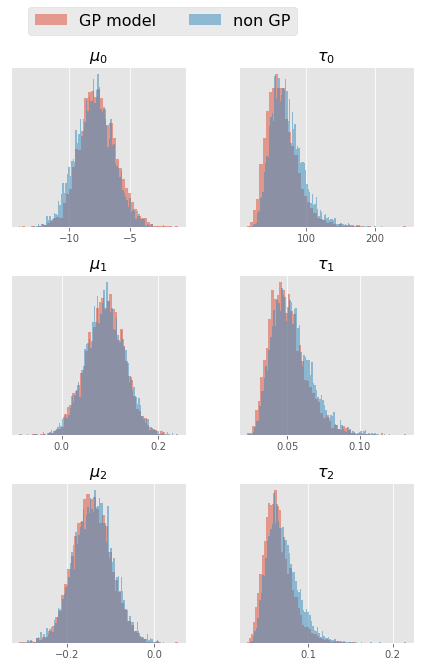

In [30]:
plt.figure(figsize=(7,10), facecolor='white')
for i in range(3):
    plt.subplot(3,2,2*i+1)
    plt.hist(trace['mus_beta'][:, i], density=True,  bins=50, alpha=.5)
    plt.hist(gb.traces['mu'][:,i], density=True,  bins=100, alpha=.5)
    plt.xticks(fontsize=10)
    plt.yticks([])
    string = str(i) 
    plt.title(fr'$\mu_{i}$')
    plt.subplot(3,2,2*i+2)
    plt.hist(trace[f'sigmas_squared_betas'][:, i], density=True,  bins=50, alpha=.5, label='GP model')
    plt.hist(gb.traces['sigmas_diag'][:,i], density=True,  bins=100, alpha=.5, label='non GP')
    if i ==0:
        plt.legend(loc=(-1.2,1.2), ncol=2)
    plt.xticks(fontsize=10)
    plt.yticks([])
    tot_string = (r'$\tau_' + '{' + string + '}$')
    plt.title(tot_string)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)
plt.savefig('../writeup/pymc_gp_model_means.png', dpi=300, bbox_inches='tight')

[None, None, None]

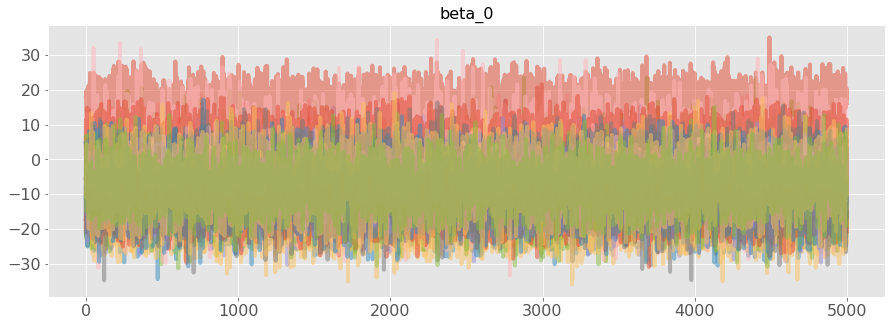

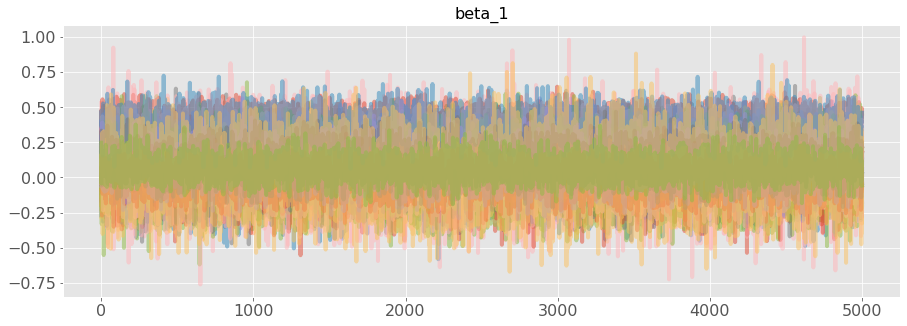

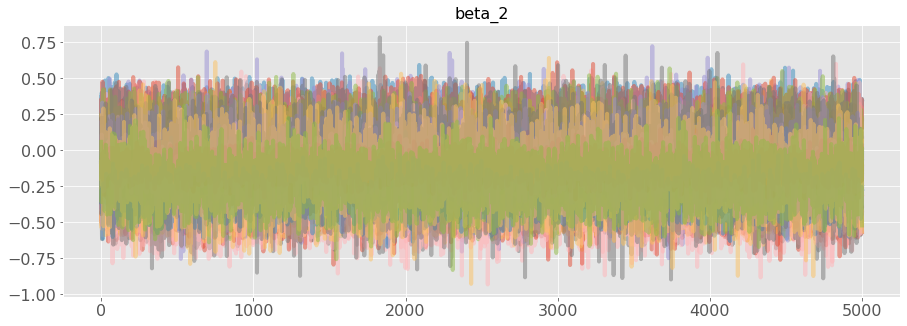

In [31]:
def plot_beta_traces(beta_num):
    plt.figure(figsize=(15,5), facecolor='white')
    plt.plot(trace[f'betas'][:, :, beta_num], alpha=.5)
    plt.title(f'beta_{beta_num}')
[plot_beta_traces(num) for num in range(3)];

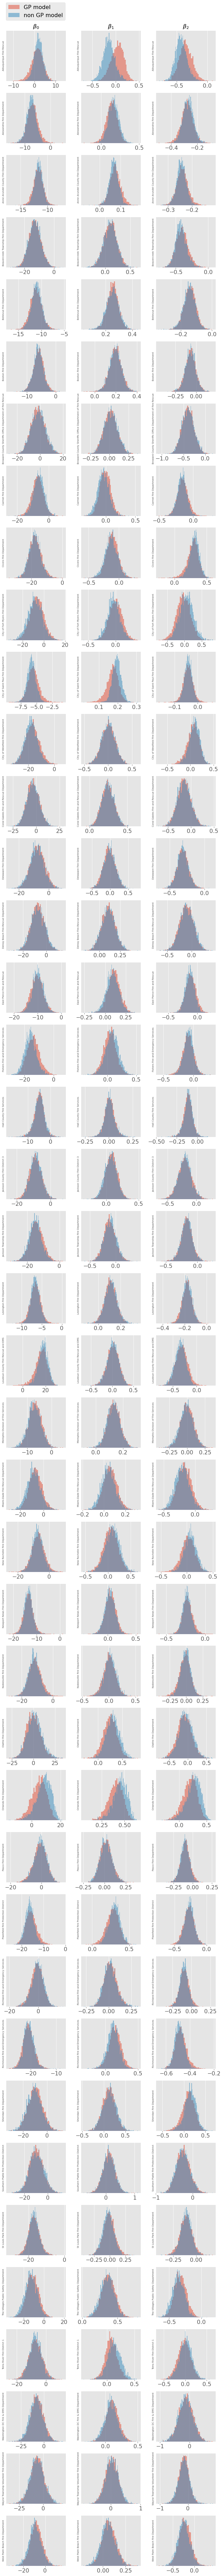

In [58]:
fig, ax = plt.subplots(figsize=(9, len(groups)*2.5), facecolor='white', ncols=3, nrows=len(groups))
for beta_num in range(3):
    for i in range(len(df.groupby('department_name').groups)):
        ax[i, beta_num].hist(trace[f'betas'][:, :, beta_num][:,i], density=True,  bins=50, alpha=.5, label='GP model')
        ax[i, beta_num].hist(gb.traces['betas'][:,beta_num,i], density=True,  bins=100, alpha=.5, label='non GP model')
        ax[i, beta_num].set_yticks([])
        if i == 0 and beta_num == 0:
            ax[i, beta_num].legend(loc=(0, 1.2))
        if i == 0:
            ax[i, beta_num].set_title(fr'$\beta_{beta_num}$')
        ax[i, beta_num].set_ylabel(dept_names[i], fontsize=7)
        
plt.tight_layout()
plt.savefig('../figures/betas_pymc_gp.png', dpi=300, bbox_inches='tight')

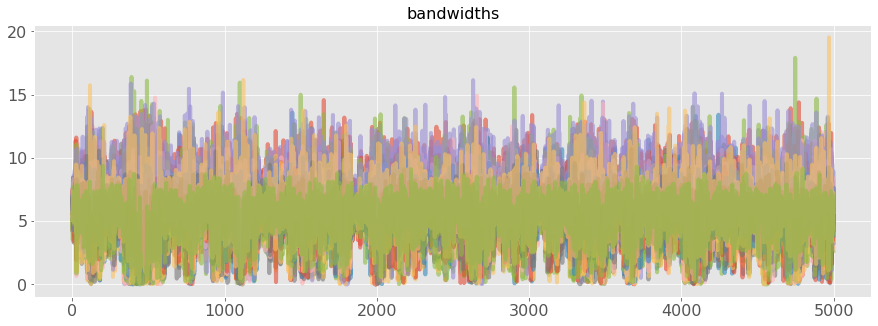

<Figure size 432x288 with 0 Axes>

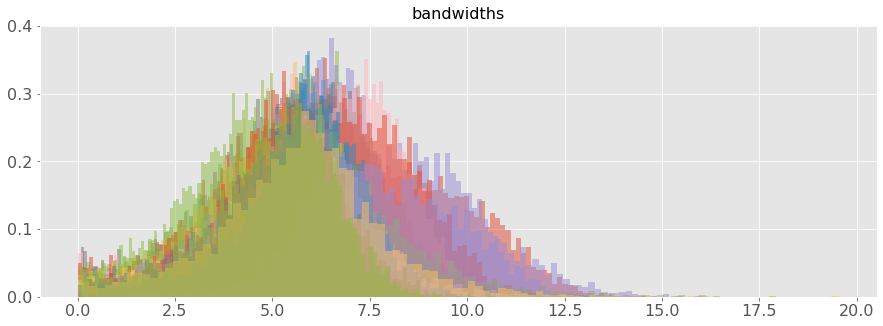

In [51]:
plt.figure(figsize=(15,5), facecolor='white')
plt.plot(trace['b'], alpha=.6)
plt.title('bandwidths');
plt.figure()
plt.figure(figsize=(15,5), facecolor='white')
for i in range(trace['b'].shape[1]):
    plt.hist(trace['b'][:, i], bins=100, density=True, alpha=.5)
plt.title('bandwidths');

(0.0, 100.0)

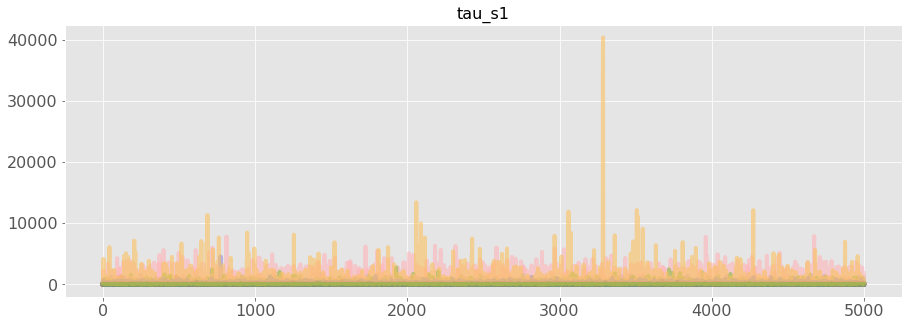

<Figure size 432x288 with 0 Axes>

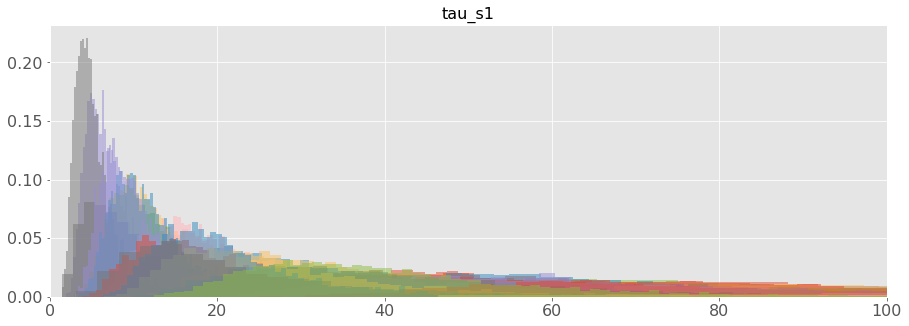

In [59]:
plt.figure(figsize=(15,5), facecolor='white')
plt.plot(trace['tau_s1'], alpha=.6)
plt.title('tau_s1')
plt.figure()
plt.figure(figsize=(15,5), facecolor='white')
for i in range(trace['tau_s1'].shape[1]):
    plt.hist(trace['tau_s1'][:, i], bins=200, density=True, alpha=.5)
plt.title('tau_s1')
plt.xlim(0, 100)

In [61]:
with model:
    predictive_checks = pm.sample_posterior_predictive(trace, return_inferencedata=False, samples=100)

NameError: name 'model' is not defined

In [62]:
col_names = ['check' + str(num) for num in range(predictive_checks['y'].shape[0])]
df[col_names] = predictive_checks['y'].T;

NameError: name 'predictive_checks' is not defined

In [27]:
def plot_checks(df, all_axes, col_names):
    ax_number = list(grouped_dataframe.groups.keys()).index(df.name)
    ax = all_axes.flatten()[ax_number]
    data = df[col_names].to_numpy()
    ax.plot(df['day_of_the_year'], df['avg_change_baseline_incidents'], color='black', zorder=3)
    ax.scatter(df['day_of_the_year'], df['avg_change_baseline_incidents'], color='red', s=100, zorder=3)
    ax.plot(df['day_of_the_year'], df[col_names], color='dodgerblue', alpha=.2)
    ax.set_title(df.name)
    ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
    ax.set_xlabel('day of 2020')
    ax.set_ylabel('% change incidents')
    plt.close()

fig, axes = plt.subplots(len(groups), 1, figsize=(20, len(groups) * 4), facecolor='white') 
grouped_dataframe = df.groupby('department_name')
grouped_dataframe.apply(lambda x: plot_checks(x, all_axes=axes, col_names=col_names))
fig.tight_layout()
fig.savefig('../figures/pred_checks.png', dpi=300, bbox_inches='tight')

/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/648952874.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1732943d0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/648952874.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x1733565f0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/648952874.py:9: UserWarning: The handle <matplotlib.lines.Line2D object at 0x17344e7d0> has a label of '_' which cannot be automatically added to the legend.
  ax.legend(['_', 'data', 'sample posterior predictive'], loc='upper right')
/var/folders/5t/ltqvfkd124z1n5v3ntgw77d40000gn/T/ipykernel_58662/648952874.py:9: UserWarning: The ha